# Installing Packages and Dependencies

In [1]:
!pip install tensorflow-text==2.4.2
!pip install tf-models-official==2.4
!pip install tensorflow-gpu==2.4.2
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

     |████████████████████████████████| 3.4 MB 898 kB/s            
     |████████████████████████████████| 394.5 MB 34 kB/s              
     |████████████████████████████████| 462 kB 49.2 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 3.8 MB 38.2 MB/s            
     |████████████████████████████████| 2.9 MB 44.3 MB/s            
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77052 sha256=245690dd82d1e58b2b7a176911aded781b98a9f8d77298052691bddfcded1962
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Succe

2022-01-12 08:25:01.977167: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
print(tf.__version__)

2.4.2


In [3]:
!nvidia-smi 

Wed Jan 12 08:25:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
tf.test.is_gpu_available()

2022-01-12 08:25:07.860786: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-12 08:25:07.861381: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-12 08:25:07.862997: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-12 08:25:07.898936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 08:25:07.899533: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla 

True

# Reading Training Data

In [5]:
df_train = pd.read_csv("../input/covid-misinfo/Constraint_English_Train.csv")
df_val = pd.read_csv("../input/covid-misinfo/Constraint_English_Val.csv")
df = pd.concat([df_train, df_val], ignore_index=True)
df.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [6]:
df.shape

(8560, 3)

# Training Data Insight

In [7]:
df.groupby('label').describe()

id                                                                 
        count         mean          std  min      25%     50%      75%     max
label                                                                         
fake   4080.0  2703.599755  1872.863928  1.0  1095.75  2193.5  4284.25  6419.0
real   4480.0  2649.909152  1884.354217  1.0  1053.75  2119.5  4275.25  6420.0

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


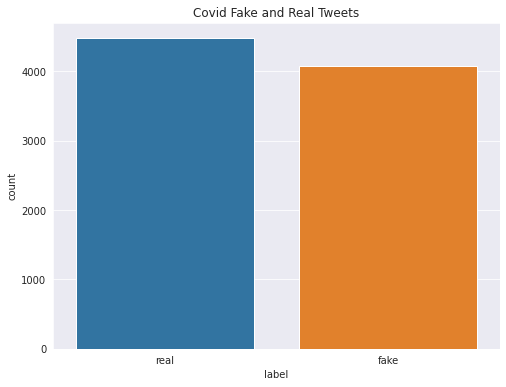

In [8]:
plt.figure(figsize=(8,6))
sns.set_style(style='darkgrid')
sns.countplot(df['label'])
plt.title("Covid Fake and Real Tweets")
plt.show()

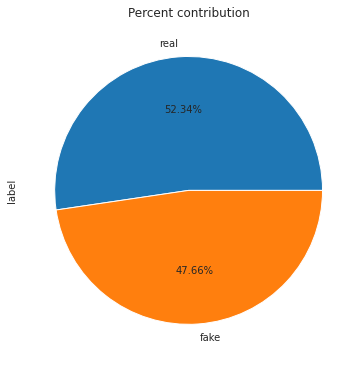

In [9]:
plt.figure(figsize=(6,8))
sns.set_style("darkgrid")
df["label"].value_counts().plot.pie(autopct='%0.2f%%')
plt.title("Percent contribution")
plt.show()

# Data Cleaning

In [10]:
#Data Cleaning
ps = PorterStemmer()
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
en_stopwords = set(stopwords.words("english"))
#en_stopwords

In [12]:
def cleaner(text):
    try:
        url_re = re.compile(r'(http|ftp|https)://([\w+?\.\w+])+([a-zA-Z0-9\~\!\@\#\$\%\^\&\*\(\)_\-\=\+\\\/\?\.\:\;\'\,]*)?')
        cleaned = url_re.sub("",text)
        
        hashtag_re = re.compile(r'(#\w+)')
        cleaned = hashtag_re.sub("",cleaned)
        
        screen_name_re = re.compile(r'(@\w+)')
        cleaned = screen_name_re.sub("", cleaned)
        
        emoji_re = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U0001F1F2-\U0001F1F4"  # Macau flag
                u"\U0001F1E6-\U0001F1FF"  # flags
                u"\U0001F600-\U0001F64F"
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u"\U0001F1F2"
                u"\U0001F1F4"
                u"\U0001F620"
                u"\u200d"
                u"\u2640-\u2642"
                "]+", flags=re.UNICODE)
        cleaned = emoji_re.sub("",cleaned)
        
        cleaned = cleaned.replace("."," ").replace("//"," ")
        cleaned = re.sub(r'[^a-zA-Z]', " ", cleaned) #Replacing all non-alphabets with " "
        cleaned = re.sub(r'\w+\d+', " ", cleaned) #Removes alphanumeric words

        cleaned = ps.stem(cleaned)

        cleaned = " ".join([word for word in cleaned.split() if len(word)>2]) #Removing words with len<2
        cleaned = " ".join([word for word in cleaned.split() if word not in en_stopwords])

        cleaned = cleaned.strip() #Removing whitespaces
        cleaned = cleaned.lower() #Converting to lower case

    except:
        cleaned = ""
    return cleaned
    
df['tweet'] = df['tweet'].apply(lambda text: cleaner(text))
df.head()

,id,tweet,label
0,1,cdc currently reports deaths general discrepan...,real
1,2,states reported deaths small rise last tuesday...,real
2,3,politically correct woman almost uses pandemic...,fake
3,4,testing laboratories india august tests done,real
4,5,populous states generate large case counts loo...,real


# Generating Word Clouds

In [13]:
df

,id,tweet,label
0,1,cdc currently reports deaths general discrepan...,real
1,2,states reported deaths small rise last tuesday...,real
2,3,politically correct woman almost uses pandemic...,fake
3,4,testing laboratories india august tests done,real
4,5,populous states generate large case counts loo...,real
...,...,...,...
8555,2136,donald trump wrongly claimed new zealand big s...,fake
8556,2137,current understanding spreads mostly person pe...,real
8557,2138,nothing screams sat around fuck lockdown quite...,fake
8558,2139,birx says covid outbreak control people move,fake


In [14]:
#Function to get word frequencies in the data
def get_word_freqs(df, col):
    text = ' '.join(df[col])
    text = text.split()
    freq = pd.Series(text).value_counts()
    return freq

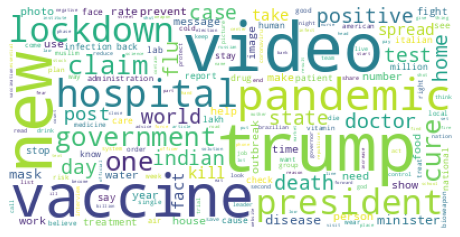

In [15]:
freq_words_fake = get_word_freqs(df[df['label']=='fake'],'tweet')
freq_words_fake = " ".join(freq_words_fake.index)
word_cloud=WordCloud(max_font_size=60,background_color='white').generate(freq_words_fake)
plt.figure(figsize=(8,6))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

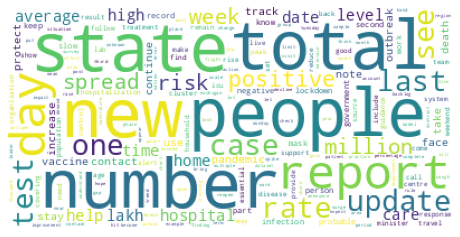

In [16]:
freq_words_real = get_word_freqs(df[df['label']=='real'],'tweet')
freq_words_real = " ".join(freq_words_real.index)
word_cloud=WordCloud(max_font_size=60,background_color='white').generate(freq_words_real)
plt.figure(figsize=(8,6))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [17]:
#splitting the labels
df_real = df[df['label']=='real']
df_real.shape

(4480, 3)

In [18]:
df_fake = df[df['label']=='fake']
df_fake.shape

(4080, 3)

# Downsampling Data

In [19]:
#unbalanced data so we downsample it
df_real_downsampled = df_real.sample(df_fake.shape[0])
df_real_downsampled.shape

(4080, 3)

In [20]:
df_balanced = pd.concat([df_fake, df_real_downsampled])
df_balanced['label'].value_counts()

fake    4080
real    4080
Name: label, dtype: int64

In [21]:
df_balanced['fake'] = df_balanced['label'].apply(lambda x: 1 if x == 'fake' else 0)
df_balanced.sample(5)

,id,tweet,label,fake
509,510,ministry home affairs india directed people po...,fake,1
2997,2998,houseflies transmit covid virus,fake,1
1683,1684,best example,fake,1
4591,4592,puts facemask skin gets lockdown get,fake,1
7434,1015,states amp uts case fatality rate cfr lower na...,real,0


# Model Construction

In [22]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

2022-01-12 08:25:28.158443: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-12 08:25:28.158771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 08:25:28.159422: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-01-12 08:25:28.159498: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-12 08:25:28.159553: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-01-12 08:25:28.159573: I tensorflow/stream_executor/platform/

In [23]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [24]:
# 3FC
#Bert Layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

#Neural Network Layers
dropout1 = tf.keras.layers.Dropout(0.1, name='dropout1')(outputs['pooled_output'])
fc1 = tf.keras.layers.Dense(512, activation='relu', name='fullyConnected1')(dropout1)
dropout2 = tf.keras.layers.Dropout(0.1, name='dropout2')(fc1)
fc2 = tf.keras.layers.Dense(256, activation='relu', name='fullyConnected2')(dropout2)
dropout3 = tf.keras.layers.Dropout(0.1, name='dropout3')(fc2)
fc3 = tf.keras.layers.Dense(128, activation='relu', name='fullyConnected3')(dropout3)
dense = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(dropout3)

#Final Model
model = tf.keras.Model(inputs=[text_input], outputs=[dense])

In [25]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=METRICS)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'sequence_output':  109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

In [26]:
X_train = df_balanced[['tweet']] 
y_train = df_balanced[['fake']]

In [27]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode="min"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=3,
                              min_delta=0.0001,
                              factor=0.2
                             )
]


# Training the Model

In [28]:
h1 = model.fit(X_train, y_train, validation_split=0.25, epochs= 50, callbacks = callbacks, verbose=1)

Epoch 1/50


2022-01-12 08:25:59.731863: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-01-12 08:26:00.451786: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


192/192 [==============================] - 64s 289ms/step - loss: 0.5895 - accuracy: 0.6881 - precision: 0.7336 - recall: 0.8344 - val_loss: 0.7374 - val_accuracy: 0.6064 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
192/192 [==============================] - 54s 281ms/step - loss: 0.3874 - accuracy: 0.8287 - precision: 0.8510 - recall: 0.9003 - val_loss: 0.5269 - val_accuracy: 0.7554 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
192/192 [==============================] - 54s 281ms/step - loss: 0.3551 - accuracy: 0.8518 - precision: 0.8731 - recall: 0.9125 - val_loss: 0.4859 - val_accuracy: 0.7652 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
192/192 [==============================] - 54s 281ms/step - loss: 0.3405 - accuracy: 0.8581 - precision: 0.8753 - recall: 0.9162 - val_loss: 0.3104 - val_accuracy: 0.8681 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
192/192 [==============================] - 54s 282ms/step - 

In [29]:
h1.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'lr'])

In [30]:
def plot_metrics(h):
    #Plotting metrics
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(h.history['loss']);
    plt.plot(h.history['val_loss']);
    plt.title("Loss vs Epochs");
    plt.ylabel("Loss");
    plt.xlabel("Epochs");
    plt.legend(['train', 'val']);

    # summarize history for accuracy
    plt.subplot(1,2,2)
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.title('Accuracy vs Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

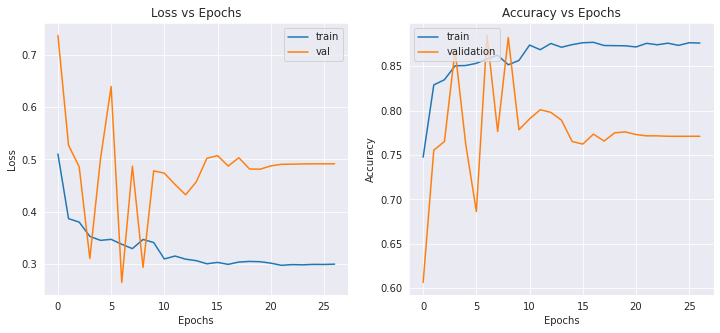

In [31]:
plot_metrics(h1)

In [32]:
model.save('BERT_2FC.h5')

# Model Evaluation on Test Data

In [33]:
df_test = pd.read_csv("../input/covid-misinfo/Constraint_English_Test.csv")
df_test['tweet'] = df_test['tweet'].apply(lambda text: cleaner(text))
df_test['fake'] = df_test['label'].apply(lambda x: 1 if x == 'fake' else 0)
X_test = df_test[['tweet']] 
y_test = df_test[['fake']]

X_test.shape

(2140, 1)

In [34]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test)

print("Test Loss: ", test_loss)
print("Test Precision: ", test_precision)
print("Test Recall: ", test_recall)
print("Test Accuracy: ", test_accuracy)

67/67 [==============================] - 14s 209ms/step - loss: 0.3606 - accuracy: 0.8421 - precision: 0.7870 - recall: 0.9167
Test Loss:  0.3605981171131134
Test Precision:  0.7870370149612427
Test Recall:  0.9166666865348816
Test Accuracy:  0.8420560956001282
